In [24]:
import sys
print(sys.path)

print(os.getcwd())

['/Users/emilyolafson/GIT/stroke-graph-matching/jupyter_code', '/Users/emilyolafson/miniforge3/envs/myenv/lib/python39.zip', '/Users/emilyolafson/miniforge3/envs/myenv/lib/python3.9', '/Users/emilyolafson/miniforge3/envs/myenv/lib/python3.9/lib-dynload', '', '/Users/emilyolafson/miniforge3/envs/myenv/lib/python3.9/site-packages', '/Users/emilyolafson/miniforge3/envs/myenv/lib/python3.9/site-packages/IPython/extensions', '/Users/emilyolafson/.ipython']
/Users/emilyolafson/GIT/stroke-graph-matching/jupyter_code


In [125]:
# adapted from Zijin Gu: https://github.com/zijin-gu/scfc-coupling
import scipy.io as sio
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

cwd = os.getcwd()
data_dir = '28andme'
roi_number = 268

def extract_fc_prec():
    fc_dir =data_dir + '/covariance/'
    subj_all = np.genfromtxt(fc_dir + 'subjects.txt', dtype = 'str')
    print(subj_all.shape[0])
    fc_corr = np.zeros([subj_all.shape[0],roi_number,roi_number])
    n = 0
    for subj in subj_all:
        fccov = sio.loadmat(fc_dir + str(subj))
        fc_corr[n] = fccov['C'] # need to use covariance
        n += 1

    # regularized precision calculation
    min_rmse = 1e5
    opt_gamma = 0
    allrmse=[]
    for gamma in np.linspace(0,1,51):
        inverse = []
        reg_inv = []
        for i in range(subj_all.shape[0]):
            np.fill_diagonal(fc_corr[i],1)
            inverse.append(np.linalg.inv(fc_corr[i]))
            #print(np.min(inverse[i]))
            #print(np.max(inverse[i]))
            reg_inv.append(np.linalg.inv(fc_corr[i] + gamma*np.eye(roi_number)))
        group_prec = np.mean(inverse, axis=0)
        
        diff = []
        for i in range(subj_all.shape[0]):
            diff.append(np.linalg.norm(reg_inv[i][np.triu_indices(roi_number,1)] - group_prec[np.triu_indices(roi_number,1)]))
        rmse = np.mean(diff)
        allrmse.append(rmse)
        if rmse < min_rmse:
            min_rmse = rmse
            opt_gamma = gamma

    fc_prec = np.zeros([subj_all.shape[0],roi_number,roi_number])
    for i in range(subj_all.shape[0]):
        fc_prec[i] = np.linalg.inv(fc_corr[i] + opt_gamma*np.eye(roi_number))

    mdic = {"C": fc_prec, "gamma": opt_gamma, "rmse":allrmse, "sub_sessID": subj_all}
    output_dir =data_dir + '/precision/'

    sio.savemat(output_dir + 'FCprec_concat_allsub.mat', mdic)
for sess in range(0,1):
    extract_fc_prec()
    #extract_fc_corr()
    


29


[[0.00321225 0.00311483 0.00303663 0.00297567 0.00293012 0.00289826
  0.0028785  0.00286941 0.00286968 0.00287813 0.00289368 0.00291541
  0.00294248 0.00297418 0.0030099  0.00304908 0.00309122 0.00313584
  0.0031825  0.00323077 0.00328026 0.0033306  0.00338146 0.00343253
  0.00348355 0.0035343  0.00358458 0.00363423 0.00368313 0.00373118
  0.00377829 0.00382443 0.00386954 0.0039136  0.0039566  0.00399853
  0.00403939 0.0040792  0.00411796 0.00415569 0.00419241 0.00422814
  0.00426291 0.00429674 0.00432964 0.00436166 0.00439281 0.00442312
  0.00445261 0.0044813  0.00450923]]


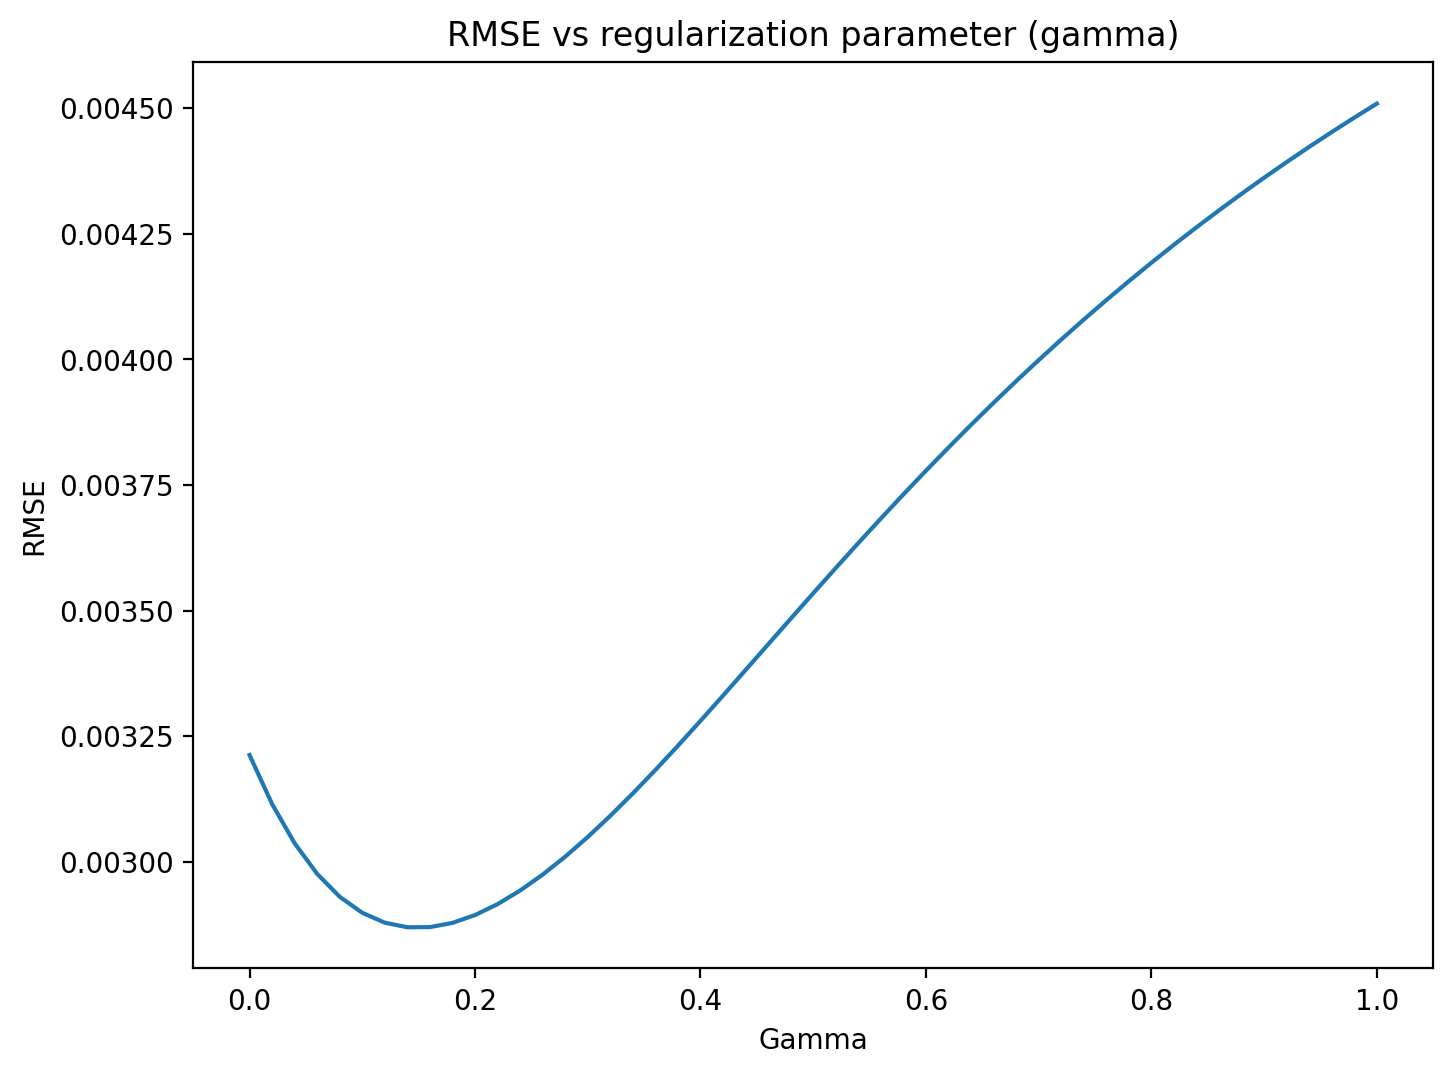

In [127]:
cwd = os.getcwd()
data_dir = '28andme'
fc_dir =data_dir + '/precision/'
output_prec = sio.loadmat(fc_dir + 'FCprec_concat_allsub.mat')
rmse = output_prec['rmse'] 
opt_gamma = output_prec['gamma'] 

gridsearch=np.linspace(0,1,51)
figure(num=None, figsize=(8, 6), dpi=200, facecolor='w', edgecolor='k')

plt.plot(gridsearch,rmse.transpose())
plt.ylabel('RMSE')
plt.xlabel('Gamma')
print(rmse)

plt.title('RMSE vs regularization parameter (gamma)')
#plt.text(opt_gamma-0.3, 0.5, 'optimal gamma = ' + str(opt_gamma[0][0]))

data_dir = '28andme/'
plt.savefig(data_dir + 'optimal_gamma.png')